In [ ]:
# 신경망 모델 훈련 

# 사이킷런에서 제공하는 머신러닝 알고리즘들은 좋은 성능을 내기 위해 매개변수를 조정하고 훈련하는 과정을 반복한다.
# 그래서 고정되어 있다고 느낄 수 있는데, 딥러닝은 직접 만드는 느낌이 강하다.

from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)


4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
# 모델을 만드는 간단한 함수를 만든다.
def model_fn(a_layer=None):
  model=keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))
  model.add(keras.layers.Dense(100,activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10,activation='softmax'))
  return model

In [ ]:
# 모델 하나 생성하고 학습.
model=model_fn()
model.summary()

model.compile(loss="sparse_categorical_crossentropy", metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss', 'accuracy'])


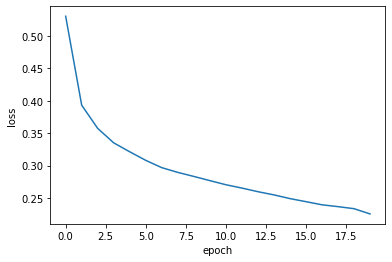

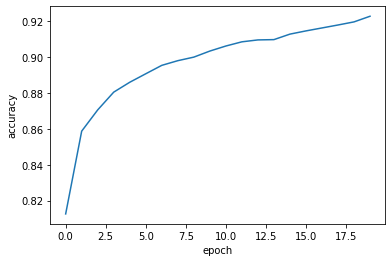

In [ ]:
print(history.history.keys())
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# 횟수가 늘어나면 손실이 줄어들긴 하는데, 과연 이게 맞는가?

In [ ]:
# 검증 손실
# 인공 신경망은 정확도가 아니라 손실 함수를 최적화 하는거다.
# 손실 함수에 비례하여 정확도가 움직이지 않는 경우도 많다.

# 검증 세트에 대한 손실 함수도 그려보자.

model = model_fn()
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
# 이렇게하면 history.history에 val_loss, val_accuracy도 있다.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [ ]:
# 과대적합을 막기 위해서 옵티마이저를 변경한다면, 기본인 RMSprop -> adam이 좋다.

# 그럼 신경망에서 사용되는 대표적인 규제 방법은 무엇인가?
# 드롭아웃 - 뉴런의 일부를 Off 하는거다. 즉, 뉴런의 출력을 0으로 만드는거다.
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

# 이 때, 드롭아웃 층은 마지막 검증 과정에서는 꼭 빼야한다.
 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


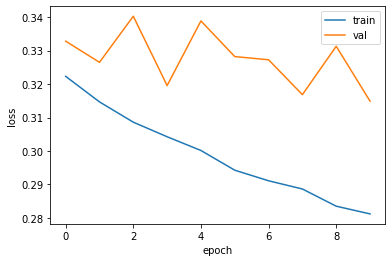

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))
# 이렇게하면 history.history에 val_loss, val_accuracy도 있다.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [ ]:
model.save_weights('model-weights.h5')
model.save('model-whole.h5')

In [ ]:
# 실험을 해보자.
# 1. 훈련을 하지 않은 새로운 모델을 만들어서 model-weights.h5 파라미터 읽어서 사용
# 2. model-whole.h5에서 새로운 모델 만들어서 바로 사용.

# 방법 1. load_weights 후 compile, evaluate -> 안함.
# 방법 2. predict로 직접 확률 계산.
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5') # 이전 모델과 완전히 같은 구조여야만 가능.
import numpy as np
# 검증 모델로 직접 검증한거다. model.predict는 12,000 * 10개의 배열로 나온다.
val_labels = np.argmax(model.predict(val_scaled),axis=-1) # axis=0이면 열 개수인 10개만 출력. 1이면 행 전부.
print(np.mean(val_labels==val_target))

# 방법 3. load_model 후 바로 evaluate
# load_model은 옵티마이저까지 전부 원래대로 복원하기 때문에 evaluate를 바로 사용할 수 있다.
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

0.8874166666666666
375/375 [==============================] - 1s 2ms/step - loss: 0.3149 - accuracy: 0.8874


[0.31489303708076477, 0.887416660785675]

# 콜백함수의 모든 것

In [ ]:
# 다른 생각: 20번 해보고나서야 10번째가 제일 좋다는 사실을 깨닫고
# 다시 10번해서 그 모델을 저장해야하나?
# 바로 10번째에 그 모델을 저장할 수 있지 않을까? -> Callback 메서드를 이용해야한다

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')

# 체크포인트 콜백함수
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)

# 조기 종료 콜백함수 (restore_best_weights 키면 가장 좋았던 파라미터로 돌린다.)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

# 콜백은 이렇게 넣는다.
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

# 가장 좋은 순간의 모델을 불러와서 평가한다.
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3219 - accuracy: 0.8834


[0.32194510102272034, 0.8834166526794434]

10


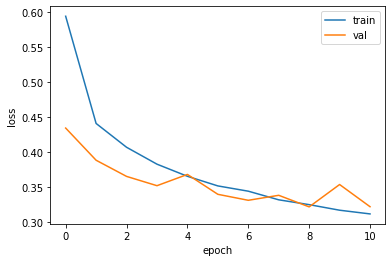

375/375 [==============================] - 1s 3ms/step - loss: 0.3219 - accuracy: 0.8834


[0.32194510102272034, 0.8834166526794434]

In [ ]:
# 결과를 확인해보자.
print(early_stopping_cb.stopped_epoch)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

model.evaluate(val_scaled, val_target)